# Projet 07 : Effectuer une prédiction de revenus

---
**Importation des librairies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.colors as plc
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
import modules_perso.sf_graphiques as sfg

---
## <font color=blue>Mission 4 : Modélisation du revenu des individus</font>

### 4.8.c. ANOVA du logarithme du revenu basée sur le produit du logarithme du revenu moyen du pays et du logarithme du revenu des parents, et sur l'indice de Gini du pays

In [4]:
data = pd.read_csv("data_analyse08.csv", index_col=0)
data["interaction_lnrm_lnpi"] = data.ln_revenu_moyen * data.ln_parent_income
data.drop(columns=["ln_revenu_moyen","ln_parent_income"], inplace=True)
data.head()

C:\Anaconda3\envs\Jupyter\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,ln_child_income,gini_from_centiles,interaction_lnrm_lnpi
0,6.591534,32.141019,52.762872
1,6.591534,32.141019,52.762872
2,6.591534,32.141019,52.762872
3,6.591534,32.141019,52.762872
4,6.591534,32.141019,52.762872


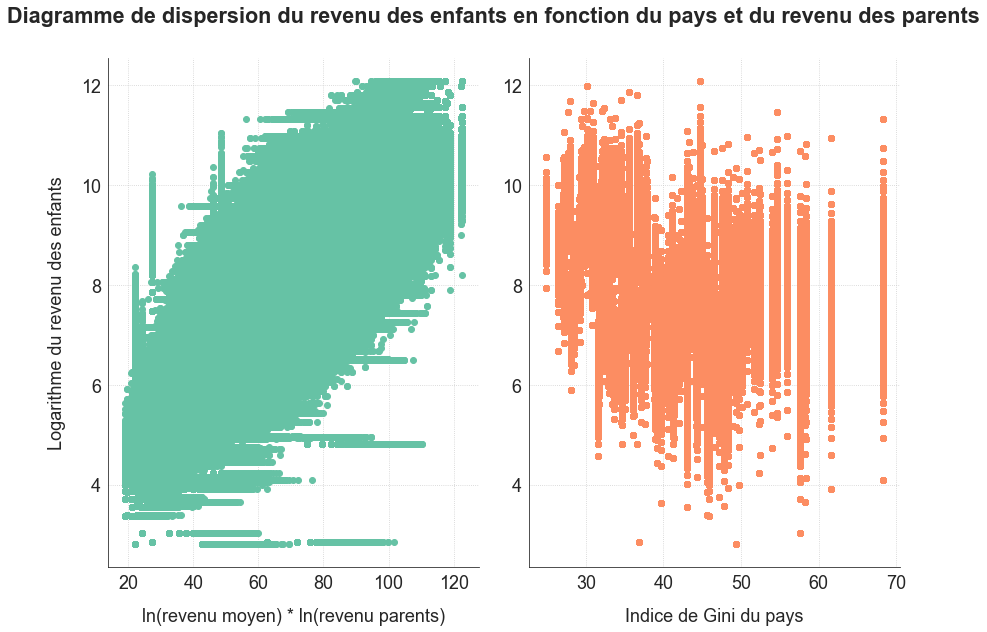

In [5]:
mygraph = sfg.MyGraph("Diagramme de dispersion du revenu des enfants en fonction du pays et du revenu des parents", nblin=1, nbcol=2, is_mono=False)
mygraph.add_plot(data.interaction_lnrm_lnpi, data.ln_child_income, label="", marker='o', color=mygraph.liste_couleurs[0], linestyle='', with_grid='both', grid_style=":", multi_index=1)
mygraph.add_plot(data.gini_from_centiles, data.ln_child_income, label="", marker='o', markeredgecolor=mygraph.liste_couleurs[1], markerfacecolor=mygraph.liste_couleurs[1], linestyle='', with_grid='both', grid_style=":", multi_index=2)
mygraph.set_axe('x', label="ln(revenu moyen) * ln(revenu parents)", multi_index=1)
mygraph.set_axe('x', label="Indice de Gini du pays", multi_index=2)
mygraph.set_axe('y', label="Logarithme du revenu des enfants", multi_index=1)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova10_00_diagramme_dispersion.png")
plt.show()

La relation linéaire croissante entre le logarithme du revenu des enfants et le produit des logarithmes du revenu des parents et du revenu moyen du pays se dessine nettement. Le nuage de point du logarithme du revenu des enfants en fonction de l'indice de Gini ne montre pas de relation évidente mais reste assez compact.

In [6]:
anova = smf.ols(formula="ln_child_income ~ interaction_lnrm_lnpi + gini_from_centiles", data=data).fit()

In [7]:
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ln_child_income   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                 1.057e+07
Date:                Mon, 14 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:16:06   Log-Likelihood:            -5.4467e+06
No. Observations:             5642420   AIC:                         1.089e+07
Df Residuals:                 5642417   BIC:                         1.089e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.0634      0.002   2214.629      0.000       4.060       4.067
interaction_lnrm_lnpi     0.0618   1.45e-05   4258.497      0.000       0.062       0.062
gini_from_centiles       -0.0059   3.18e-05   -185.211      0.000      -0.006      -0.006
==============================================================================
Omnibus:                   335072.641   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1448295.477
Skew:                          -0.087   Prob(JB):                         0.00
Kurtosis:                       5.476   Cond. No.                         536.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
interaction_lnrm_lnpi,7.319685e+06,1.0,1.813480e+07,0.0,0.761598,0.761597
gini_from_centiles,1.384562e+04,1.0,3.430304e+04,0.0,0.001441,0.001440
Residual,2.277429e+06,5642417.0,NaN,NaN,NaN,NaN
total,9.610960e+06,5642419.0,NaN,NaN,NaN,NaN


La part de dispersion expliquée par le modèle (R²) diminue légèrement par rapport au modèle 7 de base mais est la plus élevée obtenue jusqu'à maintenant avec deux variables exogènes : 78,9% de la dispersion totale. Les valeurs AIC et BIC sont également très bonnes.  
L'ANOVA conclut à la significativité des deux variables. La contribution de l'indice de Gini au modèle est très faible (omega squared = 0.001).

### Vérification des hypothèses

**Hypothèse 1 : Normalité des résidus**

In [9]:
alpha_normalite = 0.05
ad_stat, ad_pvalue = sm.stats.normal_ad(anova.resid)
norm_stat, norm_pvalue = st.kstest(anova.resid, cdf='norm', args=(anova.resid.mean(), anova.resid.var(ddof=1)))
jb_stat, jb_pvalue, skw, kurt = sm.stats.stattools.jarque_bera(anova.resid)
df_normalite = pd.DataFrame({'H0':np.repeat("Distribution normale",3), 'Statistique':["{:.2f}".format(ad_stat),"{:.2f}".format(norm_stat),"{:.2f}".format(jb_stat)], \
                             'p-value':["{:.3f}".format(ad_pvalue),"{:.3f}".format(norm_pvalue),"{:.3f}".format(jb_pvalue)]}, index=["Anderson-Darling","Kolmogorov-Smirnov","Jarque-Bera"])
inter_col = "Résultat (seuil={:.1%})".format(alpha_normalite)
df_normalite[inter_col] = ["Normalité acceptée" if float(pval)>=alpha_normalite else "Normalité rejetée" for pval in df_normalite["p-value"]]
df_normalite

C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\stats\_adnorm.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


,H0,Statistique,p-value,Résultat (seuil=5.0%)
Anderson-Darling,Distribution normale,10965.34,0.000,Normalité rejetée
Kolmogorov-Smirnov,Distribution normale,0.08,0.000,Normalité rejetée
Jarque-Bera,Distribution normale,1448295.48,0.000,Normalité rejetée


Aucun des trois test n'accepte la normalité. Nous avons un grand nombre d'observations. Une symétrie de la distribution des résidus sera suffisante. Je vérifie graphiquement cette symétrie, et je trace également la droite de Henry.

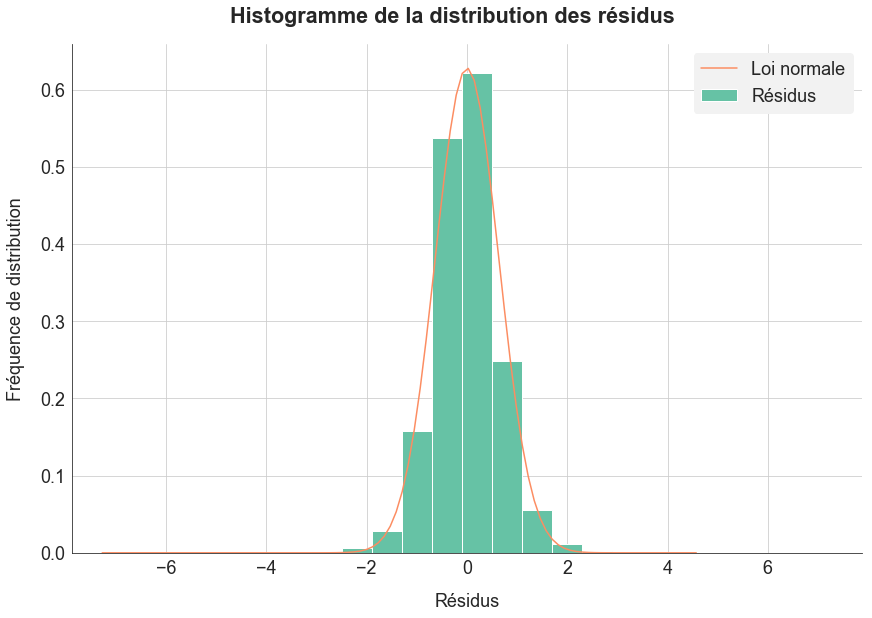

In [10]:
x_theo = np.arange(anova.resid.min(), anova.resid.max(), 0.01*(anova.resid.max()-anova.resid.min()))
mygraph = sfg.MyGraph("Histogramme de la distribution des résidus", is_mono=False)
mygraph.add_histogramme(anova.resid, bins=20, labels="Résidus")
mygraph.add_plot(x_theo, st.norm.pdf(x_theo, scale=anova.resid.std(ddof=1)), label="Loi normale", legend=True)
xmin, xmax = mygraph.ax[0].get_xlim()
absmax = max(-xmin, xmax)
mygraph.set_axe('y', label="Fréquence de distribution")
mygraph.set_axe('x', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova10_01_distribution_residus.png")
plt.show()

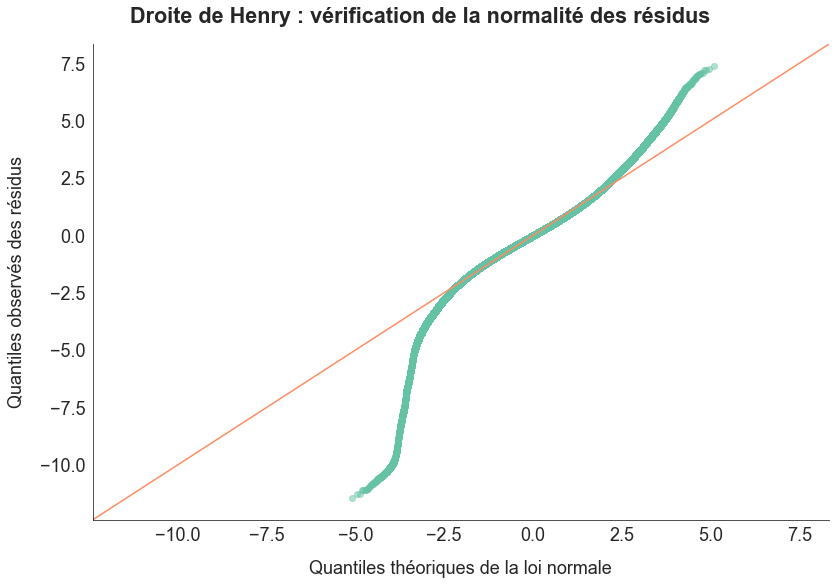

In [11]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova10_02_droite_henry.png")
plt.show()

On remarque que les résidus ne sont pas normaux. Par contre, ils présentent une symétrie assez bonne, même si elle n'est pas parfaite. Le graphique de la distribution des résidus reste satisfaisant vu le grand nombre de données de notre échantillon.  
La droite de Henry montre toujours la même difficulté de modélisation des valeurs extrêmes.

**Hypothèse 2 : Linéarité et additivité de la relation  
Hypothèse 3 : Homoscédasticité des résidus**

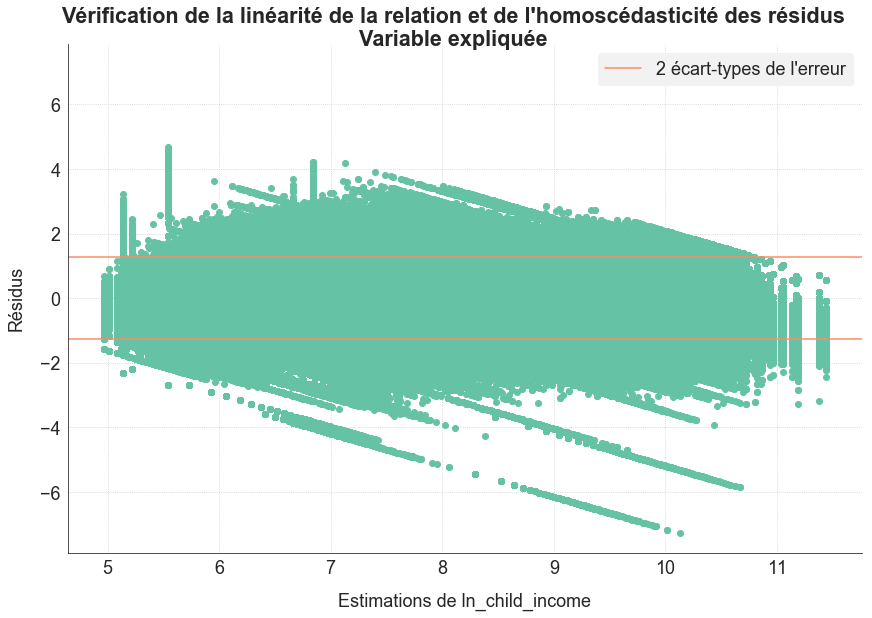

In [12]:
mygraph = sfg.MyGraph("Vérification de la linéarité de la relation et de l'homoscédasticité des résidus\nVariable expliquée", is_mono=False)
mygraph.add_plot(anova.fittedvalues, anova.resid, label="", marker='o', linestyle='', with_grid='both', grid_style=":")
yseuil = 2 * np.sqrt(table_anova.loc["Residual","sum_sq"] / table_anova.loc["Residual","df"])
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1])
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True)
ymin, ymax = mygraph.ax[0].get_ylim()
absmax = max(-ymin, ymax, 1.1*yseuil)
mygraph.set_axe('x', label="Estimations de ln_child_income")
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova10_03_linearite_homoscedasticite_endo.png")
plt.show()

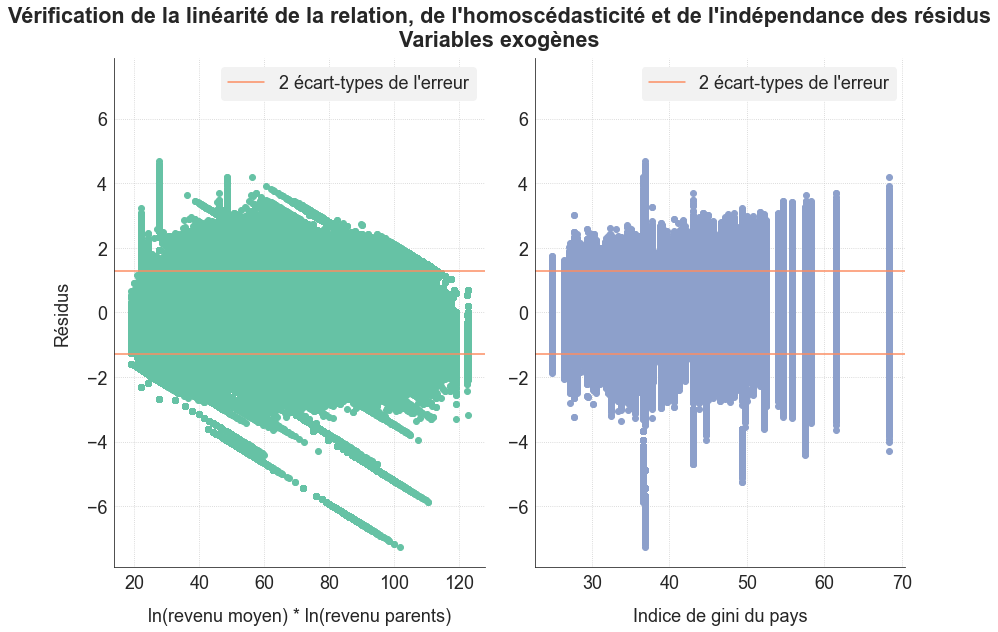

In [13]:
mygraph = sfg.MyGraph("Vérification de la linéarité de la relation, de l'homoscédasticité et de l'indépendance des résidus\nVariables exogènes", nblin=1, nbcol=2, is_mono=False)
mygraph.add_plot(data.interaction_lnrm_lnpi, anova.resid, label="", marker='o', color=mygraph.liste_couleurs[0], linestyle='', with_grid='both', grid_style=":", multi_index=1)
mygraph.add_plot(data.gini_from_centiles, anova.resid, label="", marker='o', color=mygraph.liste_couleurs[2], linestyle='', with_grid='both', grid_style=":", multi_index=2)
#yseuil = 2 * np.sqrt(table_anova.loc["Residual","sum_sq"] / table_anova.loc["Residual","df"])
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1], multi_index=1)
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True, multi_index=1)
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1], multi_index=2)
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True, multi_index=2)
ymin, ymax = mygraph.ax[0].get_ylim()
absmax = max(-ymin, ymax, 1.1*yseuil)
mygraph.set_axe('x', label="ln(revenu moyen) * ln(revenu parents)", multi_index=1)
mygraph.set_axe('x', label="Indice de gini du pays", multi_index=2)
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax, multi_index=1)
mygraph.set_axe('y', tick_min=-absmax, tick_max=absmax, multi_index=2)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova10_04_linearite_homoscedasticite_exo.png")
plt.show()

In [14]:
# MEMORY ERROR - Graphiques précédents suffisants
alpha_homo = 0.05
lm_stat, lm_pvalue, f_stat, f_pvalue = sm.stats.diagnostic.het_breuschpagan(anova.resid, anova.model.exog)
if f_pvalue >= alpha_homo:
    test_result = ["Homoscédasticité acceptée"]
else:
    test_result = ["Homoscédasticité rejetée"]
pd.DataFrame({'H0':["Variance des résidus constante"], 'Statistique':["{:.2f}".format(f_stat)], \
             'p-value':["{:.3f}".format(f_pvalue)], 'Résultat (seuil={:.1%})'.format(alpha_homo):test_result}, index=["Breusch Pagan"])

,H0,Statistique,p-value,Résultat (seuil=5.0%)
Breusch Pagan,Variance des résidus constante,92649.74,0.000,Homoscédasticité rejetée


L'homoscédasticité est rejetée par le test. Par contre, les graphiques montrent que les résidus sont désormais assez bien répartis dans les valeurs positives et négatives. Les graphiques sont satisfaisants et permettent de valider les hypothèses d'homoscédasticité des résidus et de linéarité de la relation.  
Les résidus semblent un peu dépendants de la valeur de l'interaction : ils tendent à être moins élevés quand l'interaction augmente.

**Conclusion sur les hypothèses**

Les graphiques permettent d'accepter les 3 hypothèses, en gardant en mémoire le potentiel problème de dépendance des résidus avec l'interaction.

**Vérification supplémentaire : absence de colinéarité entre les exogènes**

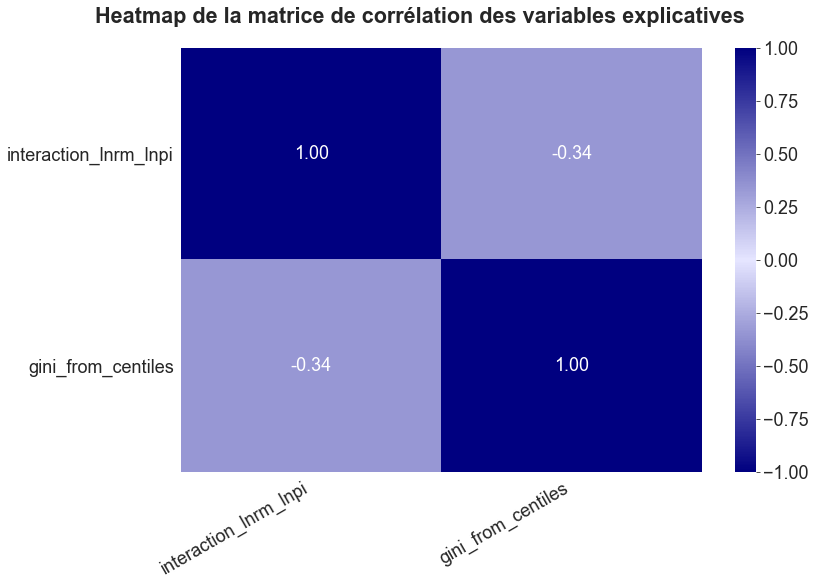

In [15]:
matrice_correl = np.corrcoef(data[["interaction_lnrm_lnpi","gini_from_centiles"]], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=["interaction_lnrm_lnpi","gini_from_centiles"], rotation=0)
mygraph.set_axe('x', tick_labels=["interaction_lnrm_lnpi","gini_from_centiles"], rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova10_05_matrice_correl.png")
plt.show()

In [16]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
interaction_lnrm_lnpi,1.130398
gini_from_centiles,1.130398


Il n'y a pas de problème de colinéarité.

**Vérification de la pertinence des estimations par rapport aux valeurs réelles**

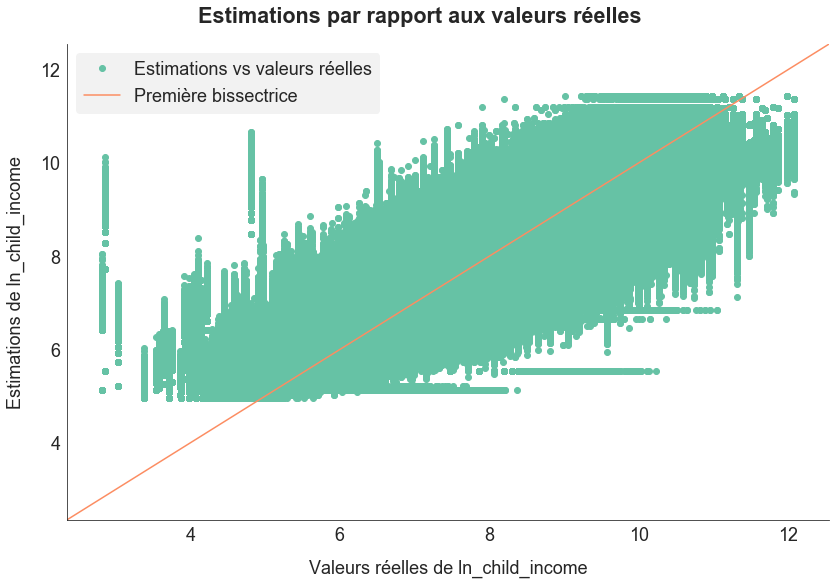

In [17]:
mygraph = sfg.MyGraph("Estimations par rapport aux valeurs réelles", is_mono=False)
mygraph.add_plot(data.ln_child_income, anova.fittedvalues, label="Estimations vs valeurs réelles", marker='o', linestyle="")
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="Première bissectrice", legend=True)
mygraph.set_axe('y', label="Estimations de ln_child_income")
mygraph.set_axe('x', label="Valeurs réelles de ln_child_income")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova10_06_accuracy_graph.png")
plt.show()

Les valeurs extrêmes sont moins bien modélisées par ce modèle que le modèle 7 qui sert de base à cette variante.

**Analyse des outliers**

In [18]:
n, p = anova.model.exog.shape
p = p - 1  # j'enlève la constante du nombre de paramètres pour ajuster les seuils
seuils = pd.Series(index=["levier", "resid_student", "dffits", "cook","dfbetas"])
seuils.levier = 2 * (p + 1) / n
seuils.dffits = 2 * np.sqrt((p + 1) / n)
seuils.cook = 4 / (n - p - 1)
seuils.resid_student = st.t.ppf(1-(0.05/2), n-p-2)  # seuil de 5% pour les résidus studentisés
reg_influence = anova.get_influence()
analyses = pd.DataFrame({"observation_name":data.index})
analyses["levier"] = reg_influence.hat_matrix_diag
#analyses["external_resid_student"] = reg_influence.resid_studentized_external
#analyses["outlier"] = ((analyses.levier > seuils.levier) | (abs(analyses.external_resid_student) > seuils.resid_student))
analyses["outlier"] = analyses.levier > seuils.levier
#analyses["dffits"] = reg_influence.dffits[0]
analyses["cook_distance"] = reg_influence.cooks_distance[0]
analyses["influence"] = analyses.cook_distance > seuils.cook
#analyses["influence"] = (abs(analyses.dffits) > seuils.dffits) | (analyses.cook_distance > seuils.cook)

In [19]:
seuils[["levier","cook"]].to_frame().style.format("{:.8f}")

,0
levier,0.00000106
cook,0.00000071


In [20]:
only_both = False
if only_both == False:
    print("Résumé des observations atypiques OU influentes")
    variables_speciales = analyses[(analyses.outlier | analyses.influence) & (analyses.outlier != analyses.influence)]
    print(variables_speciales)
    print("")
print("Résumé des observations atypiques ET influentes")
variables_investigation = analyses[analyses.outlier & analyses.influence]
variables_investigation

Résumé des observations atypiques OU influentes
         observation_name        levier  outlier  cook_distance  influence
49349               49349  3.483613e-07    False   1.298236e-06       True
49350               49350  3.446911e-07    False   1.256777e-06       True
49351               49351  3.412940e-07    False   1.218182e-06       True
49352               49352  3.412940e-07    False   1.218182e-06       True
49353               49353  3.360729e-07    False   1.158281e-06       True
49354               49354  3.360729e-07    False   1.158281e-06       True
49355               49355  3.354678e-07    False   1.151281e-06       True
49356               49356  3.336285e-07    False   1.129915e-06       True
49357               49357  3.336285e-07    False   1.129915e-06       True
49358               49358  3.326296e-07    False   1.118249e-06       True
49359               49359  3.326296e-07    False   1.118249e-06       True
49360               49360  3.319199e-07    False   1

,observation_name,levier,outlier,cook_distance,influence
150033,150033,0.000001,True,6.056763e-06,True
150034,150034,0.000001,True,6.056763e-06,True
150535,150535,0.000001,True,3.948643e-06,True
151539,151539,0.000001,True,3.266148e-06,True
151540,151540,0.000001,True,3.266148e-06,True
151541,151541,0.000001,True,3.266148e-06,True
152537,152537,0.000001,True,2.823110e-06,True
153039,153039,0.000001,True,2.697746e-06,True
153040,153040,0.000001,True,2.697746e-06,True
153538,153538,0.000001,True,2.587105e-06,True


**Conclusion sur cette variante**

La potentielle dépendance des résidus avec le logarithme du revenu des parents pose un vrai problème.  
L'autre point négatif est la mauvaise estimation des valeurs extrêmes par rapport aux modèles précédents.  
  
Ces deux points amènent à rejeter cette variante.